In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

Num GPUs Available:  1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)


### 프로젝트 수행 요건

프로젝트를 진행하면서 다음 사항들을 필수로 수행해야 합니다:

1. **데이터 증강 (Augmentation) 적용**: 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습합니다. 사용한 augmentation 방법을 명시해주세요.

2. **U-Net Generator 사용**: 이전에 구현했던 두 개의 Generator 중, Encoder와 Decoder 간에 skip connection이 있는 U-Net Generator를 사용해 주세요.

3. **모델 학습 및 테스트**: 모델을 학습한 후, 학습된 Generator를 이용하여 테스트를 수행합니다. 테스트 데이터로는 다운로드한 "val" 폴더 내의 이미지를 사용합니다.

4. **시각화**: 테스트 과정을 거친 1개 이상의 이미지에 대해, 스케치, 생성된 사진, 실제 사진을 순서대로 나란히 시각화해 주세요.

5. **학습 로그**: 모델을 충분히 학습하기 위한 시간이 부족할 수 있습니다. 최소 10 epoch 이상 학습하며, 중간에 발생하는 손실 값에 대한 로그를 남겨주세요. 테스트 결과가 완벽하지 않아도 괜찮으며, 좋은 결과를 얻기 위해서는 긴 학습 시간이 필요합니다.도 괜찮습니다.

| 항목명명 | 상세기술 |
|---|---|
| pix2pix 모델 학습을 위해 필요한 데이터셋의 증강 | 데이터셋 품질 및 학습 가능 데이터의 augmentation을 통한 데이터셋 구축 과정이 제시되어야 합니다. |
| pix2pix 모델을 구현하여 성능을 높이는 방안 구축 | U-Net generator, discriminator 모델 구축에 있어서의 [train_step()] output을 확인하고 개선하였습니다. |
| 학습 결과 및 테스트에 대한 시각적 결과물 제출 | 10 epoch 이상의 학습을 진행한 결과물 리스트 결과에서 전반적인 epoch 수에 걸친 중간 결과물을 확인하였습니다. |


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## 데이터 로드

In [4]:
data_path ='cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [5]:
%pip install pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os

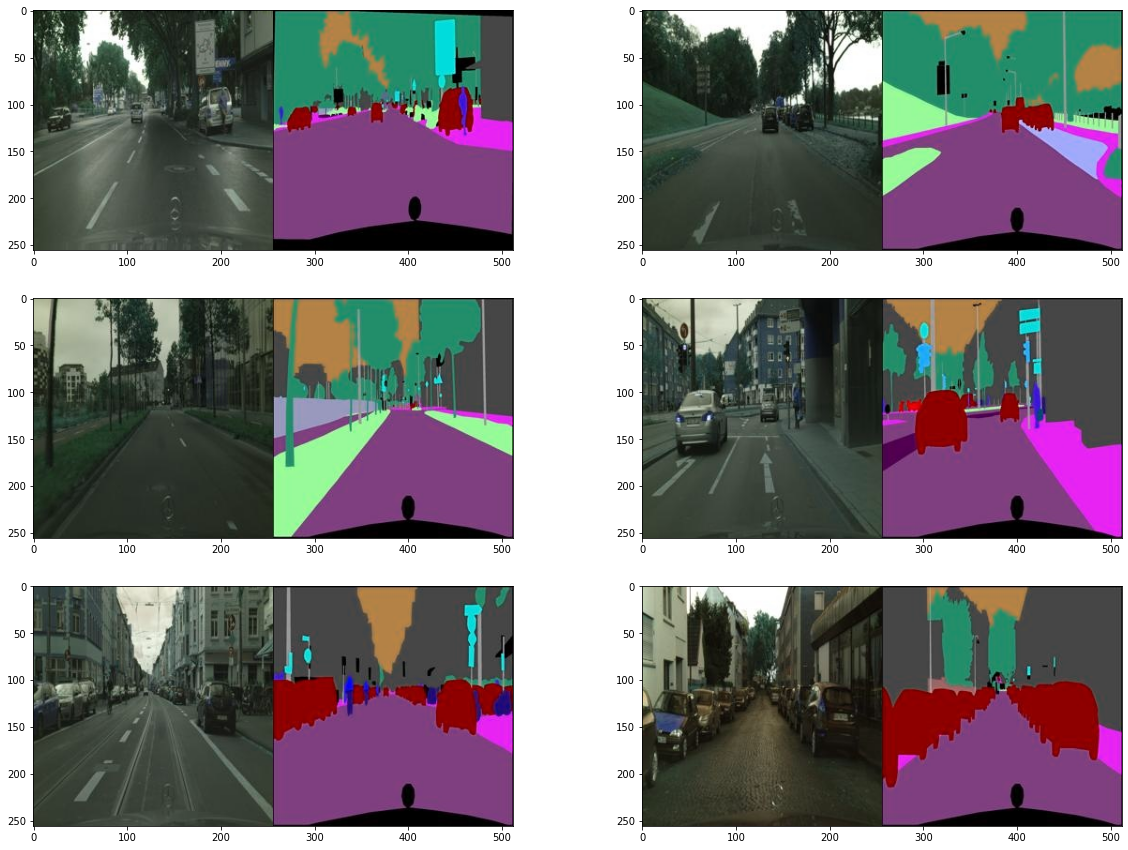

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [8]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


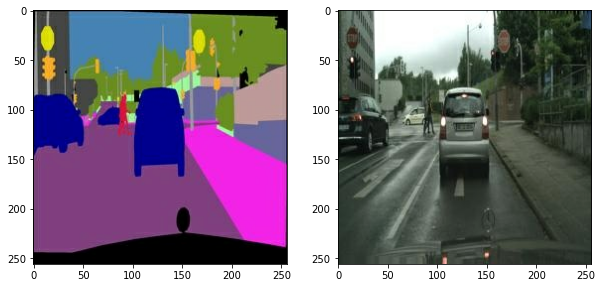

In [9]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
colored,sketch = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [10]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(colored, sketch):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


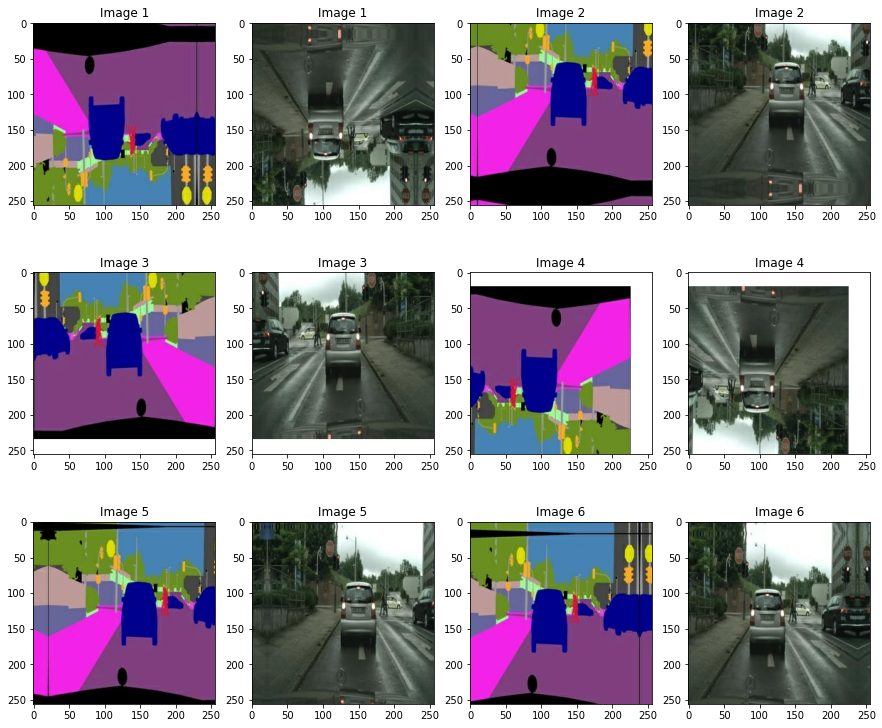

In [11]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_colored, augmented_sketch = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

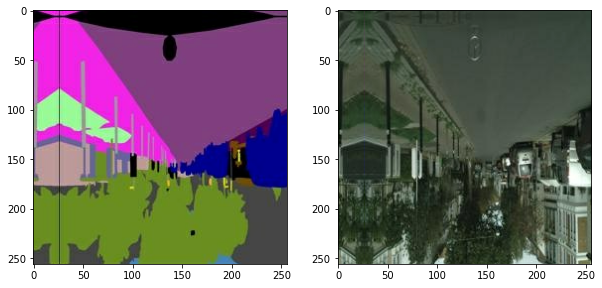

In [12]:
from tensorflow import data
    
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
colored, sketch = (sample[0][1]+1)*127.5, (sample[0][0]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [13]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [14]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]

        # EncoderBlock을 쌓습니다.
        self.blocks = [] 
        for i, f in enumerate(filters):
            # 첫 번째 블록에서는 Batch Normalization을 생략합니다.
            self.blocks.append(EncodeBlock(f, use_bn=(i != 0)))

    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        model = Model(inputs, self.call(inputs))
        return model.summary()

print("✅")


✅


In [15]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [16]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        # DecodeBlock들을 쌓습니다.
        self.blocks = []
        for i, f in enumerate(filters):
            # 처음 3개의 블록에는 Dropout 적용
            self.blocks.append(DecodeBlock(f, dropout=(i < 3)))
        # 마지막 Conv2DTranspose 레이어 추가
        self.final_transconv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.final_transconv(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        model = Model(inputs, self.call(inputs))
        return model.summary()
print("✅")

✅


In [17]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [18]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


In [19]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [20]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [21]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

In [22]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [23]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64, 128, 256, 512, 1]

        # 첫 번째 레이어로 Concatenate를 추가합니다.
        self.concat = layers.Concatenate()

        # DiscBlock 레이어를 쌓습니다.
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                # 처음 3개 블록에서는 stride=2, custom padding과 batch normalization 사용 안 함
                self.blocks.append(DiscBlock(f, stride=2, custom_pad=False, use_bn=False))
            else:
                # 나머지 블록에서는 stride=1, custom padding 사용
                use_bn = i != 4  # 마지막 블록에서는 batch normalization 사용 안 함
                self.blocks.append(DiscBlock(f, stride=1, custom_pad=True, use_bn=use_bn))

        # 마지막에 sigmoid 활성화 함수 적용
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x, y):
        # Concatenate를 적용합니다.
        x = self.concat([x, y])

        for block in self.blocks:
            x = block(x)
        out = self.sigmoid(x)
        return out
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

print("✅")


✅


In [24]:
Discriminator().get_summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

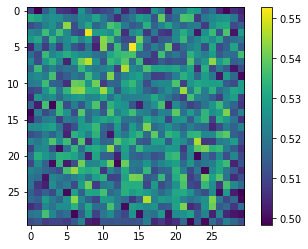

In [25]:
import tensorflow as tf
import matplotlib.pyplot as plt

x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [26]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    total_gen_loss = gene_loss + (100 * l1_loss)

    return total_gen_loss, gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [27]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [32]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        total_gen_loss, gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)

    gene_gradient = gene_tape.gradient(total_gen_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return total_gen_loss , l1_loss, disc_loss

In [33]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, ( colored, sketch) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:31.2776                     
L1_loss:0.3030                     
Discriminator_loss:1.4522

EPOCH[1] - STEP[20]                     
Generator_loss:27.1624                     
L1_loss:0.2634                     
Discriminator_loss:1.4051

EPOCH[1] - STEP[30]                     
Generator_loss:36.4075                     
L1_loss:0.3571                     
Discriminator_loss:1.3952

EPOCH[1] - STEP[40]                     
Generator_loss:26.7400                     
L1_loss:0.2591                     
Discriminator_loss:1.3457

EPOCH[1] - STEP[50]                     
Generator_loss:26.2823                     
L1_loss:0.2546                     
Discriminator_loss:1.3975

EPOCH[1] - STEP[60]                     
Generator_loss:29.3037                     
L1_loss:0.2862                     
Discriminator_loss:1.2758

EPOCH[1] - STEP[70]                     
Generator_loss:26.1319                     
L1_loss:0.2541             

EPOCH[3] - STEP[70]                     
Generator_loss:20.6425                     
L1_loss:0.1974                     
Discriminator_loss:0.8342

EPOCH[3] - STEP[80]                     
Generator_loss:24.1667                     
L1_loss:0.2335                     
Discriminator_loss:0.7453

EPOCH[3] - STEP[90]                     
Generator_loss:23.8071                     
L1_loss:0.2286                     
Discriminator_loss:0.6670

EPOCH[3] - STEP[100]                     
Generator_loss:21.4321                     
L1_loss:0.2048                     
Discriminator_loss:0.7317

EPOCH[3] - STEP[110]                     
Generator_loss:21.3795                     
L1_loss:0.2041                     
Discriminator_loss:0.6315

EPOCH[3] - STEP[120]                     
Generator_loss:19.3014                     
L1_loss:0.1825                     
Discriminator_loss:1.2155

EPOCH[3] - STEP[130]                     
Generator_loss:20.5404                     
L1_loss:0.1952         

EPOCH[5] - STEP[130]                     
Generator_loss:21.6710                     
L1_loss:0.2011                     
Discriminator_loss:0.3767

EPOCH[5] - STEP[140]                     
Generator_loss:21.8963                     
L1_loss:0.2025                     
Discriminator_loss:0.2782

EPOCH[5] - STEP[150]                     
Generator_loss:22.4935                     
L1_loss:0.2075                     
Discriminator_loss:0.2475

EPOCH[5] - STEP[160]                     
Generator_loss:22.2546                     
L1_loss:0.2102                     
Discriminator_loss:0.4359

EPOCH[5] - STEP[170]                     
Generator_loss:20.4889                     
L1_loss:0.1865                     
Discriminator_loss:0.2833

EPOCH[5] - STEP[180]                     
Generator_loss:20.5552                     
L1_loss:0.1871                     
Discriminator_loss:0.2266

EPOCH[5] - STEP[190]                     
Generator_loss:28.8414                     
L1_loss:0.2710      

EPOCH[7] - STEP[190]                     
Generator_loss:17.1840                     
L1_loss:0.1595                     
Discriminator_loss:0.8539

EPOCH[7] - STEP[200]                     
Generator_loss:25.0268                     
L1_loss:0.2397                     
Discriminator_loss:0.6085

EPOCH[7] - STEP[210]                     
Generator_loss:21.1109                     
L1_loss:0.1979                     
Discriminator_loss:0.4894

EPOCH[7] - STEP[220]                     
Generator_loss:20.5460                     
L1_loss:0.1948                     
Discriminator_loss:0.8676

EPOCH[7] - STEP[230]                     
Generator_loss:20.0314                     
L1_loss:0.1899                     
Discriminator_loss:0.4930

EPOCH[7] - STEP[240]                     
Generator_loss:15.2765                     
L1_loss:0.1388                     
Discriminator_loss:1.0683

EPOCH[7] - STEP[250]                     
Generator_loss:18.2737                     
L1_loss:0.1739      

EPOCH[9] - STEP[250]                     
Generator_loss:18.1342                     
L1_loss:0.1688                     
Discriminator_loss:0.4850

EPOCH[10] - STEP[10]                     
Generator_loss:16.8661                     
L1_loss:0.1586                     
Discriminator_loss:1.3961

EPOCH[10] - STEP[20]                     
Generator_loss:18.6243                     
L1_loss:0.1726                     
Discriminator_loss:0.5274

EPOCH[10] - STEP[30]                     
Generator_loss:18.5207                     
L1_loss:0.1723                     
Discriminator_loss:0.5670

EPOCH[10] - STEP[40]                     
Generator_loss:21.1615                     
L1_loss:0.2048                     
Discriminator_loss:0.8857

EPOCH[10] - STEP[50]                     
Generator_loss:17.1715                     
L1_loss:0.1582                     
Discriminator_loss:0.4893

EPOCH[10] - STEP[60]                     
Generator_loss:17.4547                     
L1_loss:0.1630      

EPOCH[12] - STEP[50]                     
Generator_loss:15.1462                     
L1_loss:0.1333                     
Discriminator_loss:0.8387

EPOCH[12] - STEP[60]                     
Generator_loss:15.5611                     
L1_loss:0.1442                     
Discriminator_loss:0.4495

EPOCH[12] - STEP[70]                     
Generator_loss:17.5926                     
L1_loss:0.1651                     
Discriminator_loss:0.5360

EPOCH[12] - STEP[80]                     
Generator_loss:17.0064                     
L1_loss:0.1557                     
Discriminator_loss:0.8264

EPOCH[12] - STEP[90]                     
Generator_loss:17.0590                     
L1_loss:0.1564                     
Discriminator_loss:1.6601

EPOCH[12] - STEP[100]                     
Generator_loss:21.4635                     
L1_loss:0.2104                     
Discriminator_loss:1.5638

EPOCH[12] - STEP[110]                     
Generator_loss:16.4978                     
L1_loss:0.1571    

EPOCH[14] - STEP[100]                     
Generator_loss:18.3339                     
L1_loss:0.1693                     
Discriminator_loss:1.1306

EPOCH[14] - STEP[110]                     
Generator_loss:19.0961                     
L1_loss:0.1760                     
Discriminator_loss:0.3090

EPOCH[14] - STEP[120]                     
Generator_loss:16.5907                     
L1_loss:0.1498                     
Discriminator_loss:0.5335

EPOCH[14] - STEP[130]                     
Generator_loss:16.0098                     
L1_loss:0.1410                     
Discriminator_loss:0.5681

EPOCH[14] - STEP[140]                     
Generator_loss:18.3657                     
L1_loss:0.1685                     
Discriminator_loss:0.4231

EPOCH[14] - STEP[150]                     
Generator_loss:16.7442                     
L1_loss:0.1575                     
Discriminator_loss:0.8446

EPOCH[14] - STEP[160]                     
Generator_loss:19.7392                     
L1_loss:0.182

EPOCH[16] - STEP[150]                     
Generator_loss:21.7659                     
L1_loss:0.2018                     
Discriminator_loss:0.2754

EPOCH[16] - STEP[160]                     
Generator_loss:19.6643                     
L1_loss:0.1797                     
Discriminator_loss:0.2672

EPOCH[16] - STEP[170]                     
Generator_loss:17.6958                     
L1_loss:0.1607                     
Discriminator_loss:0.6633

EPOCH[16] - STEP[180]                     
Generator_loss:12.4162                     
L1_loss:0.1086                     
Discriminator_loss:0.3392

EPOCH[16] - STEP[190]                     
Generator_loss:15.3913                     
L1_loss:0.1463                     
Discriminator_loss:0.7259

EPOCH[16] - STEP[200]                     
Generator_loss:20.2353                     
L1_loss:0.1816                     
Discriminator_loss:0.4658

EPOCH[16] - STEP[210]                     
Generator_loss:19.6423                     
L1_loss:0.193

EPOCH[18] - STEP[200]                     
Generator_loss:19.3311                     
L1_loss:0.1811                     
Discriminator_loss:0.3889

EPOCH[18] - STEP[210]                     
Generator_loss:17.7248                     
L1_loss:0.1577                     
Discriminator_loss:0.7305

EPOCH[18] - STEP[220]                     
Generator_loss:13.2661                     
L1_loss:0.1207                     
Discriminator_loss:1.2173

EPOCH[18] - STEP[230]                     
Generator_loss:16.4921                     
L1_loss:0.1519                     
Discriminator_loss:0.5220

EPOCH[18] - STEP[240]                     
Generator_loss:15.5047                     
L1_loss:0.1438                     
Discriminator_loss:0.5211

EPOCH[18] - STEP[250]                     
Generator_loss:16.7328                     
L1_loss:0.1524                     
Discriminator_loss:0.5923

EPOCH[19] - STEP[10]                     
Generator_loss:18.4766                     
L1_loss:0.1659

EPOCH[20] - STEP[250]                     
Generator_loss:15.9482                     
L1_loss:0.1470                     
Discriminator_loss:0.4986

EPOCH[21] - STEP[10]                     
Generator_loss:16.5792                     
L1_loss:0.1567                     
Discriminator_loss:0.5830

EPOCH[21] - STEP[20]                     
Generator_loss:18.1449                     
L1_loss:0.1682                     
Discriminator_loss:0.3383

EPOCH[21] - STEP[30]                     
Generator_loss:17.8851                     
L1_loss:0.1566                     
Discriminator_loss:1.0468

EPOCH[21] - STEP[40]                     
Generator_loss:14.3587                     
L1_loss:0.1312                     
Discriminator_loss:0.5433

EPOCH[21] - STEP[50]                     
Generator_loss:14.5439                     
L1_loss:0.1345                     
Discriminator_loss:0.5658

EPOCH[21] - STEP[60]                     
Generator_loss:18.2909                     
L1_loss:0.1633     

EPOCH[23] - STEP[50]                     
Generator_loss:14.5821                     
L1_loss:0.1341                     
Discriminator_loss:0.8551

EPOCH[23] - STEP[60]                     
Generator_loss:15.3283                     
L1_loss:0.1308                     
Discriminator_loss:1.5448

EPOCH[23] - STEP[70]                     
Generator_loss:17.6481                     
L1_loss:0.1630                     
Discriminator_loss:0.4545

EPOCH[23] - STEP[80]                     
Generator_loss:15.9106                     
L1_loss:0.1533                     
Discriminator_loss:1.0763

EPOCH[23] - STEP[90]                     
Generator_loss:19.3159                     
L1_loss:0.1809                     
Discriminator_loss:0.5135

EPOCH[23] - STEP[100]                     
Generator_loss:18.1953                     
L1_loss:0.1612                     
Discriminator_loss:0.7717

EPOCH[23] - STEP[110]                     
Generator_loss:14.7739                     
L1_loss:0.1339    

EPOCH[25] - STEP[100]                     
Generator_loss:15.8118                     
L1_loss:0.1391                     
Discriminator_loss:0.7507

EPOCH[25] - STEP[110]                     
Generator_loss:16.2933                     
L1_loss:0.1503                     
Discriminator_loss:0.5949

EPOCH[25] - STEP[120]                     
Generator_loss:13.4677                     
L1_loss:0.1233                     
Discriminator_loss:0.5035

EPOCH[25] - STEP[130]                     
Generator_loss:13.9805                     
L1_loss:0.1258                     
Discriminator_loss:0.4244

EPOCH[25] - STEP[140]                     
Generator_loss:12.6798                     
L1_loss:0.1091                     
Discriminator_loss:1.1479

EPOCH[25] - STEP[150]                     
Generator_loss:16.7887                     
L1_loss:0.1506                     
Discriminator_loss:0.8424

EPOCH[25] - STEP[160]                     
Generator_loss:16.1727                     
L1_loss:0.146

EPOCH[27] - STEP[150]                     
Generator_loss:16.1249                     
L1_loss:0.1419                     
Discriminator_loss:0.7977

EPOCH[27] - STEP[160]                     
Generator_loss:18.5363                     
L1_loss:0.1714                     
Discriminator_loss:0.3052

EPOCH[27] - STEP[170]                     
Generator_loss:19.0135                     
L1_loss:0.1718                     
Discriminator_loss:0.8378

EPOCH[27] - STEP[180]                     
Generator_loss:17.0369                     
L1_loss:0.1642                     
Discriminator_loss:0.9665

EPOCH[27] - STEP[190]                     
Generator_loss:14.9513                     
L1_loss:0.1276                     
Discriminator_loss:1.7606

EPOCH[27] - STEP[200]                     
Generator_loss:22.5261                     
L1_loss:0.2157                     
Discriminator_loss:0.5262

EPOCH[27] - STEP[210]                     
Generator_loss:17.1688                     
L1_loss:0.162

EPOCH[29] - STEP[200]                     
Generator_loss:16.9704                     
L1_loss:0.1529                     
Discriminator_loss:0.3704

EPOCH[29] - STEP[210]                     
Generator_loss:18.8679                     
L1_loss:0.1564                     
Discriminator_loss:2.0269

EPOCH[29] - STEP[220]                     
Generator_loss:14.3760                     
L1_loss:0.1314                     
Discriminator_loss:0.3919

EPOCH[29] - STEP[230]                     
Generator_loss:18.5772                     
L1_loss:0.1636                     
Discriminator_loss:0.9183

EPOCH[29] - STEP[240]                     
Generator_loss:21.3956                     
L1_loss:0.2096                     
Discriminator_loss:1.4902

EPOCH[29] - STEP[250]                     
Generator_loss:14.9267                     
L1_loss:0.1372                     
Discriminator_loss:1.5229

EPOCH[30] - STEP[10]                     
Generator_loss:16.3065                     
L1_loss:0.1529

EPOCH[31] - STEP[250]                     
Generator_loss:17.4236                     
L1_loss:0.1555                     
Discriminator_loss:0.6938

EPOCH[32] - STEP[10]                     
Generator_loss:18.1197                     
L1_loss:0.1710                     
Discriminator_loss:0.5136

EPOCH[32] - STEP[20]                     
Generator_loss:14.8346                     
L1_loss:0.1313                     
Discriminator_loss:0.3837

EPOCH[32] - STEP[30]                     
Generator_loss:19.0848                     
L1_loss:0.1729                     
Discriminator_loss:0.3855

EPOCH[32] - STEP[40]                     
Generator_loss:13.9427                     
L1_loss:0.1328                     
Discriminator_loss:0.9798

EPOCH[32] - STEP[50]                     
Generator_loss:18.0432                     
L1_loss:0.1703                     
Discriminator_loss:0.8670

EPOCH[32] - STEP[60]                     
Generator_loss:15.6092                     
L1_loss:0.1409     

EPOCH[34] - STEP[50]                     
Generator_loss:19.3292                     
L1_loss:0.1749                     
Discriminator_loss:1.0049

EPOCH[34] - STEP[60]                     
Generator_loss:14.1799                     
L1_loss:0.1252                     
Discriminator_loss:0.2569

EPOCH[34] - STEP[70]                     
Generator_loss:21.9611                     
L1_loss:0.2027                     
Discriminator_loss:0.2177

EPOCH[34] - STEP[80]                     
Generator_loss:15.0992                     
L1_loss:0.1370                     
Discriminator_loss:0.5035

EPOCH[34] - STEP[90]                     
Generator_loss:13.6678                     
L1_loss:0.1238                     
Discriminator_loss:0.8862

EPOCH[34] - STEP[100]                     
Generator_loss:13.9641                     
L1_loss:0.1246                     
Discriminator_loss:0.7933

EPOCH[34] - STEP[110]                     
Generator_loss:14.4097                     
L1_loss:0.1269    

EPOCH[36] - STEP[100]                     
Generator_loss:17.9295                     
L1_loss:0.1642                     
Discriminator_loss:0.3530

EPOCH[36] - STEP[110]                     
Generator_loss:13.0246                     
L1_loss:0.1161                     
Discriminator_loss:0.3887

EPOCH[36] - STEP[120]                     
Generator_loss:13.7978                     
L1_loss:0.1285                     
Discriminator_loss:0.6107

EPOCH[36] - STEP[130]                     
Generator_loss:14.6571                     
L1_loss:0.1345                     
Discriminator_loss:1.2240

EPOCH[36] - STEP[140]                     
Generator_loss:19.4777                     
L1_loss:0.1892                     
Discriminator_loss:1.4587

EPOCH[36] - STEP[150]                     
Generator_loss:16.3919                     
L1_loss:0.1427                     
Discriminator_loss:0.2558

EPOCH[36] - STEP[160]                     
Generator_loss:13.5803                     
L1_loss:0.116

EPOCH[38] - STEP[150]                     
Generator_loss:16.8283                     
L1_loss:0.1597                     
Discriminator_loss:0.6819

EPOCH[38] - STEP[160]                     
Generator_loss:18.6006                     
L1_loss:0.1674                     
Discriminator_loss:0.2145

EPOCH[38] - STEP[170]                     
Generator_loss:15.5391                     
L1_loss:0.1356                     
Discriminator_loss:1.8675

EPOCH[38] - STEP[180]                     
Generator_loss:18.9011                     
L1_loss:0.1776                     
Discriminator_loss:0.4519

EPOCH[38] - STEP[190]                     
Generator_loss:14.4419                     
L1_loss:0.1305                     
Discriminator_loss:0.3362

EPOCH[38] - STEP[200]                     
Generator_loss:17.5471                     
L1_loss:0.1695                     
Discriminator_loss:1.1190

EPOCH[38] - STEP[210]                     
Generator_loss:21.8677                     
L1_loss:0.207

EPOCH[40] - STEP[200]                     
Generator_loss:15.6250                     
L1_loss:0.1439                     
Discriminator_loss:1.0213

EPOCH[40] - STEP[210]                     
Generator_loss:14.3311                     
L1_loss:0.1262                     
Discriminator_loss:0.7556

EPOCH[40] - STEP[220]                     
Generator_loss:19.6891                     
L1_loss:0.1807                     
Discriminator_loss:0.3759

EPOCH[40] - STEP[230]                     
Generator_loss:14.0237                     
L1_loss:0.1215                     
Discriminator_loss:1.1053

EPOCH[40] - STEP[240]                     
Generator_loss:17.1892                     
L1_loss:0.1538                     
Discriminator_loss:0.4277

EPOCH[40] - STEP[250]                     
Generator_loss:12.8428                     
L1_loss:0.1157                     
Discriminator_loss:0.5152

EPOCH[41] - STEP[10]                     
Generator_loss:14.3173                     
L1_loss:0.1382

EPOCH[42] - STEP[250]                     
Generator_loss:23.2984                     
L1_loss:0.2115                     
Discriminator_loss:0.2831

EPOCH[43] - STEP[10]                     
Generator_loss:20.8133                     
L1_loss:0.1978                     
Discriminator_loss:0.8413

EPOCH[43] - STEP[20]                     
Generator_loss:20.3098                     
L1_loss:0.1927                     
Discriminator_loss:0.4757

EPOCH[43] - STEP[30]                     
Generator_loss:17.6946                     
L1_loss:0.1663                     
Discriminator_loss:0.5100

EPOCH[43] - STEP[40]                     
Generator_loss:21.4200                     
L1_loss:0.2032                     
Discriminator_loss:0.4686

EPOCH[43] - STEP[50]                     
Generator_loss:12.8763                     
L1_loss:0.1152                     
Discriminator_loss:1.2378

EPOCH[43] - STEP[60]                     
Generator_loss:12.8390                     
L1_loss:0.1134     

EPOCH[45] - STEP[50]                     
Generator_loss:16.7361                     
L1_loss:0.1502                     
Discriminator_loss:0.3648

EPOCH[45] - STEP[60]                     
Generator_loss:15.1554                     
L1_loss:0.1367                     
Discriminator_loss:0.6080

EPOCH[45] - STEP[70]                     
Generator_loss:16.2916                     
L1_loss:0.1512                     
Discriminator_loss:0.4229

EPOCH[45] - STEP[80]                     
Generator_loss:12.7685                     
L1_loss:0.1200                     
Discriminator_loss:0.7518

EPOCH[45] - STEP[90]                     
Generator_loss:17.2386                     
L1_loss:0.1673                     
Discriminator_loss:1.2793

EPOCH[45] - STEP[100]                     
Generator_loss:12.1451                     
L1_loss:0.1141                     
Discriminator_loss:1.3437

EPOCH[45] - STEP[110]                     
Generator_loss:16.7128                     
L1_loss:0.1541    

EPOCH[47] - STEP[100]                     
Generator_loss:14.0579                     
L1_loss:0.1295                     
Discriminator_loss:0.6984

EPOCH[47] - STEP[110]                     
Generator_loss:12.7881                     
L1_loss:0.1189                     
Discriminator_loss:0.5951

EPOCH[47] - STEP[120]                     
Generator_loss:18.8663                     
L1_loss:0.1712                     
Discriminator_loss:0.3830

EPOCH[47] - STEP[130]                     
Generator_loss:21.1854                     
L1_loss:0.1984                     
Discriminator_loss:0.3318

EPOCH[47] - STEP[140]                     
Generator_loss:12.9587                     
L1_loss:0.1176                     
Discriminator_loss:0.5050

EPOCH[47] - STEP[150]                     
Generator_loss:14.9108                     
L1_loss:0.1378                     
Discriminator_loss:0.4871

EPOCH[47] - STEP[160]                     
Generator_loss:14.3497                     
L1_loss:0.135

EPOCH[49] - STEP[150]                     
Generator_loss:14.4505                     
L1_loss:0.1361                     
Discriminator_loss:1.5653

EPOCH[49] - STEP[160]                     
Generator_loss:20.4897                     
L1_loss:0.1891                     
Discriminator_loss:0.3317

EPOCH[49] - STEP[170]                     
Generator_loss:12.6605                     
L1_loss:0.1106                     
Discriminator_loss:0.7384

EPOCH[49] - STEP[180]                     
Generator_loss:15.5836                     
L1_loss:0.1449                     
Discriminator_loss:0.6746

EPOCH[49] - STEP[190]                     
Generator_loss:14.2227                     
L1_loss:0.1246                     
Discriminator_loss:0.5980

EPOCH[49] - STEP[200]                     
Generator_loss:14.2217                     
L1_loss:0.1272                     
Discriminator_loss:1.0902

EPOCH[49] - STEP[210]                     
Generator_loss:16.6304                     
L1_loss:0.154

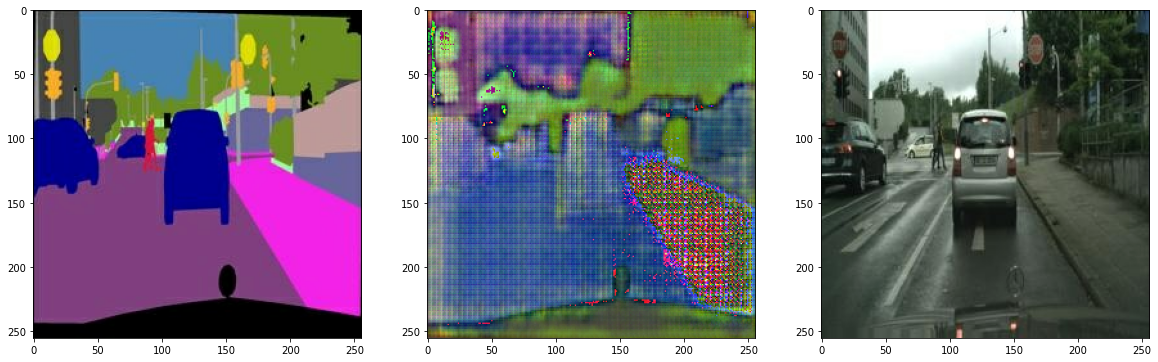

In [34]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
colored, sketch = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))